## Решение

 * Добавить отслежевание точности. 
 * Увеличить к-во эпох обучения. хотябы до 200.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import warnings # Не показывать предупреждения.
warnings.filterwarnings('ignore')

2021-09-16 20:51:17.609368: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
path_to_file = 'evgenyi_onegin.txt'

In [3]:
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

# length of text is the number of characters in it
print('Length of text: {} characters'.format(len(text)))

Length of text: 286984 characters


In [4]:
print(text[:500])

Александр Сергеевич Пушкин

                                Евгений Онегин
                                Роман в стихах

                        Не мысля гордый свет забавить,
                        Вниманье дружбы возлюбя,
                        Хотел бы я тебе представить
                        Залог достойнее тебя,
                        Достойнее души прекрасной,
                        Святой исполненной мечты,
                        Поэзии живой и ясной,
                        Высо


In [5]:
text = text + text

In [6]:
# The unique characters in the file
#  Отсортируем все символы в датасете и удалим повтряющиеся. 
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))

131 unique characters


In [7]:
# Creating a mapping from unique characters to indices
#  Сделаем перевод номеров симоволов в текст. 
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [8]:
text_as_int, text[:30], len(text_as_int), len(text)

(array([ 71, 110, 104, ..., 104, 121,   0]),
 'Александр Сергеевич Пушкин\n\n  ',
 573968,
 573968)

### train and target

In [9]:
# The maximum length sentence you want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int) # ? Вот здесь не очень понятно. Зачем берут числа а не символы.

for i in char_dataset.take(5):
    print(idx2char[i.numpy()])

2021-09-16 20:51:35.534542: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-09-16 20:51:35.661286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-16 20:51:35.662765: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 6 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 104.43GiB/s
2021-09-16 20:51:35.662857: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-09-16 20:51:36.124285: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-09-16 20:51:36.124387: I tensorflow/stream_executor/pl

А
л
е
к
с


In [10]:
char_dataset.take(5)

<TakeDataset shapes: (), types: tf.int64>

In [11]:
# Выполним разбиение текста на последовательности длинной 100 символов.
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

# Выведем первые 5 батчей на экран.
for item in sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))

'Александр Сергеевич Пушкин\n\n                                Евгений Онегин\n                          '
'      Роман в стихах\n\n                        Не мысля гордый свет забавить,\n                        '
'Вниманье дружбы возлюбя,\n                        Хотел бы я тебе представить\n                        '
'Залог достойнее тебя,\n                        Достойнее души прекрасной,\n                        Свят'
'ой исполненной мечты,\n                        Поэзии живой и ясной,\n                        Высоких д'


In [12]:
def split_input_target(chunk):
    input_text = chunk[:-1] # Предсказываем по одному символу.
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [13]:
dataset

# Разделим его на тренировочную и тестовую выборки.

<MapDataset shapes: ((100,), (100,)), types: (tf.int64, tf.int64)>

Print the first example input and target values:

In [14]:
for input_example, target_example in  dataset.take(1):
    print('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
    print('Target data:', repr(''.join(idx2char[target_example.numpy()])))

2021-09-16 20:51:46.496988: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-16 20:51:46.517178: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2799925000 Hz


Input data:  'Александр Сергеевич Пушкин\n\n                                Евгений Онегин\n                         '
Target data: 'лександр Сергеевич Пушкин\n\n                                Евгений Онегин\n                          '


In [15]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).

BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [16]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 128

# Number of RNN units
rnn_units = 1024

In [17]:
class RNNgenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units): #, batch_size):
        super(RNNgenerator, self).__init__()
        
        self.emb = tf.keras.layers.Embedding(vocab_size, embedding_dim) #, batch_input_shape=[batch_size, None])
                                 
        self.gru1 = tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=False,
                            recurrent_initializer='glorot_uniform')

        self.gru2 = tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=False,
                            recurrent_initializer='glorot_uniform')
        self.gru3 = tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=False,
                            recurrent_initializer='glorot_uniform')
        
        # self.lin_norm = tf.keras.layers.LayerNormalization()

        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, x):
        emb_x = self.emb(x)
        x = self.gru1(emb_x)
        x = self.gru2(x)
        x = self.gru3(x)

        x = self.dense(x)
        return x 

model = RNNgenerator(vocab_size,
                     embedding_dim,
                     rnn_units=rnn_units
                     ) #,
                    #  batch_size= BATCH_SIZE)
                     
# model.build(tf.TensorShape([1, None]))

In [18]:
# model.summary()

## Train the model

In [19]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

# example_batch_loss = loss(target_example_batch, example_batch_predictions)
# print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
# print("scalar_loss:      ", example_batch_loss.numpy().mean())

In [20]:
model.compile(optimizer='adam', loss=loss, metrics='accuracy')

### Configure checkpoints

In [21]:
# Directory where the checkpoints will be saved
checkpoint_dir = './RNN_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_prefix,
                                save_freq=5,
                                save_weights_only=True)

### Execute the training

In [22]:
EPOCHS = 500

In [23]:
history = model.fit(dataset,
                    epochs=EPOCHS,
                    callbacks=[checkpoint_callback]
                   )

Epoch 1/3


2021-09-16 20:51:54.628025: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-09-16 20:51:59.794477: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8204
2021-09-16 20:52:01.203034: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-09-16 20:52:06.971112: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


88/88 [==============================] - 100s 946ms/step - loss: 1.9549 - accuracy: 0.5610
Epoch 2/3
88/88 [==============================] - 83s 941ms/step - loss: 1.4236 - accuracy: 0.6066
Epoch 3/3
88/88 [==============================] - 87s 988ms/step - loss: 1.2866 - accuracy: 0.6317


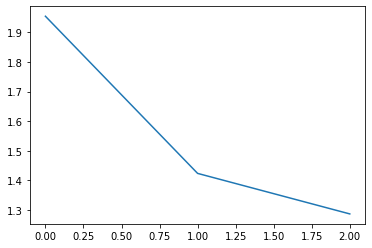

In [24]:
plt.plot(history.history['loss'])
plt.show()

## Generate text

In [25]:
tf.train.latest_checkpoint(checkpoint_dir)

'./RNN_checkpoints/ckpt_3'

In [26]:
# Востановим модель из кеша.

In [27]:
model = RNNgenerator(vocab_size, embedding_dim, rnn_units) #, batch_size=BATCH_SIZE)
# )
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

## Генерация текста.

In [42]:
# Number of characters to generate
num_generate = 500

# Low temperature results in more predictable text.
# Higher temperature results in more surprising text.
# Experiment to find the best setting.
temperature = 0.7

In [44]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        
        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [45]:
text_ = generate_text(model, start_string=u"И вот идет уже ")
print(text_)

И вот идет уже смы,                                                                                                                                                            И.
  Ныро                  
                          Ва                                       пPужь
            ба                                        пPи           Во                                                                                                                    О
                                                   


# Попробуем обучить модель с сохранением состояния.

In [31]:
class RNNgenerator_1(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru1 = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.gru2 = tf.keras.layers.GRU(rnn_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
    self.gru3 = tf.keras.layers.GRU(rnn_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, x, states=None, return_state=False):

    x = self.embedding(x)

    if states is None:
      states = self.gru1.get_initial_state(x)

    x, states = self.gru1(x, initial_state=states)
    x, states = self.gru2(x, initial_state=states)
    x, states = self.gru3(x, initial_state=states)

    x = self.dense(x)

    if return_state:
      return x, states
    else:
      return x

In [32]:
# Directory where the checkpoints will be saved
checkpoint_dir = './RNN_1_checkpoints'

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_prefix,
                                save_freq=1,
                                save_weights_only=True)

In [33]:
model_1 = RNNgenerator_1(
                 vocab_size= vocab_size,
                 embedding_dim=embedding_dim,
                 rnn_units=rnn_units,
                )

In [34]:
model_1.compile(optimizer='adam', loss=loss, metrics='accuracy')

In [35]:
history = model_1.fit(dataset,
                    epochs=EPOCHS,
                    callbacks=[checkpoint_callback])

Epoch 1/3
88/88 [==============================] - 351s 4s/step - loss: 2.0020 - accuracy: 0.5595
Epoch 2/3
88/88 [==============================] - 270s 3s/step - loss: 1.4610 - accuracy: 0.6020
Epoch 3/3
88/88 [==============================] - 264s 3s/step - loss: 1.3003 - accuracy: 0.6286


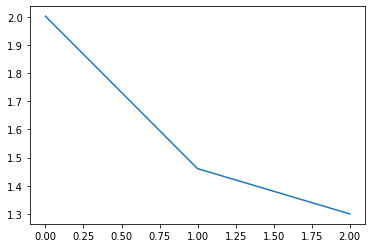

In [36]:
plt.plot(history.history['loss'])
plt.show()

## Генерация текста.

In [37]:
def generate_text_1(model, start_string, states, temperature):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions, states = model(input_eval, states=states, return_state=True)
        predictions = tf.squeeze(predictions, 0)
        
        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [40]:
num_generate = 500
temperature = 0.7
states = None
next_char = u"И вот идет уже "
text_generated=[]

In [41]:
text = generate_text_1(model_1, next_char, states, temperature)
print(text)

И вот идет уже тдМВЮ
    ТъЬTv7tsPAe3ЮВСра?     ЕClЬm1apH1q1eа
  ГuL8:
  ОЭkи
   X4clhten15}
 рB'Gyы?
  ТzfoaYbь  B3pсзби
   ра  Тпо л0а   Г2t? Тыхи
 дрoa3iу.
   Вл:
 у Незай П1yAe5я
   LX1pls7Ю  (XLuИ
 ПЛgwzе
 Озу
      И I1I}.
     ОР?     Зижыхсскьме Ясже V
  Лd0Ий!
  ОM2p.
 Ка  X51Ш2Ьz0vы
  Е?  XV3eo4'pо
 Бzpе  Нgо     I
  Ву XX5
  Чы
   Вола  ПЮMgшю
 Соссшегой  Гg2ad}  Вы
  II3eooя
 Сза   На   ПX3osRlO  Вво ПM2u4Iь,
 Сва  Оэ   ОЗO  (Л3fЬeEpO
   МB6W
 Чо.
 З9ttт'oя
    ЕoI8у
  XuI3?
  п(    ДеКы
  Т7NgnlyV


# Model 2

In [ ]:
class RNNgenerator_2(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru1 = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.gru2 = tf.keras.layers.GRU(rnn_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
    self.gru3 = tf.keras.layers.GRU(rnn_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, x, states_1=None, states_2=None, states_3=None, return_state=False):

    x = self.embedding(x)

    if states is None:
      states_1 = self.gru1.get_initial_state(x)
      states_2 = self.gru1.get_initial_state(x)
      states_3 = self.gru1.get_initial_state(x)

    x, states_1 = self.gru1(x, initial_state=states_1)
    x, states_2 = self.gru2(x, initial_state=states_2)
    x, states_3 = self.gru3(x, initial_state=states_3)

    x = self.dense(x)

    if return_state:
      return x, states_1, states_2, states_3
    else:
      return x

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './RNN_2_checkpoints'

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_prefix,
                                save_freq=1,
                                save_weights_only=True)

In [ ]:
model_2 = RNNgenerator_2(
                 vocab_size= vocab_size,
                 embedding_dim=embedding_dim,
                 rnn_units=rnn_units,
                )

In [ ]:
model_2.compile(optimizer='adam', loss=loss, metrics='accuracy')

In [ ]:
history = model_2.fit(dataset,
                    epochs=EPOCHS,
                    callbacks=[checkpoint_callback])

In [ ]:
plt.plot(history.history['loss'])
plt.show()

In [ ]:
def generate_text_2(model, start_string, states_1, states_2, states_3, temperature):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions, states = model(input_eval, states_1=states_1, states_2=states_2, states_3=states_3, return_state=True)
        predictions = tf.squeeze(predictions, 0)
        
        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [ ]:
num_generate = 500
temperature = 0.7
states = None
next_char = u"И вот идет уже "
text_generated=[]

In [ ]:
text = generate_text_2(model_2, next_char, states_1, states_2, states_3, temperature)
print(text)